<a href="https://colab.research.google.com/github/Varshini2906/Hybrid-Approach---Early-Yield-Detection-using-EWMA-and-LSTM/blob/main/Refined_code_yield_drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After running the above cell, you will be prompted to authorize Google Drive access. Once authorized, your Drive will be mounted at `/content/drive`.

Now, let's navigate to the `secom` folder within your Google Drive. Make sure the folder exists in your Drive.

In [3]:
import os

# Change to the 'secom' directory within your mounted Google Drive
secom_path = '/content/drive/My Drive/secom'

if os.path.exists(secom_path):
    os.chdir(secom_path)
    print(f"Successfully changed current directory to: {os.getcwd()}")
else:
    print(f"Error: The folder '{secom_path}' does not exist. Please ensure it is present in your Google Drive.")
    print("Current directory is still: ", os.getcwd())

Successfully changed current directory to: /content/drive/My Drive/secom


**Formal definition (important)**

drift defined as:

A sustained increase in predicted failure risk over time, beyond historical variability.

Plan:

  1.Train a static failure predictor (XGBoost)

  2.Use its out-of-sample risk scores as a proxy drift signal

  3.Train an LSTM to forecast this signal ahead in time

  4.Trigger early drift alerts when forecasted risk exceeds a statistical threshold

This is a hybrid early-warning system, not post-hoc detection.

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [121]:
#Load and clean data (NaNs preserved)

import pandas as pd
import numpy as np


df = pd.read_csv(
    f"{secom_path}/secom.data",
    sep=" ",
    header=None,
    na_values=["NaN"]
)

print("Sensor shape:", df.shape)

labels = pd.read_csv(
    f"{secom_path}/secom_labels.data",
    sep=" ",
    header=None,
    names=["label", "timestamp"],
    quotechar='"'
)

assert len(df) == len(labels), "Row mismatch between X and labels"

#Convert labels to binary (required for XGBoost)
y = (labels["label"] == 1).astype(int)

print(y.value_counts())

df['label'] = y.values
df = df.reset_index(drop=True)
df

Sensor shape: (1567, 590)
label
0    1463
1     104
Name: count, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,0
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,0
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,0
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,0


STRICT TEMPORAL SPLIT

In [122]:
# -------------------------------
# STRICT TEMPORAL SPLIT
# -------------------------------

TIME_SPLIT = int(len(df) * 0.7)

train_df = df.iloc[:TIME_SPLIT].copy()
test_df  = df.iloc[TIME_SPLIT:].copy()

print("Train size:", train_df.shape)
print("Test size :", test_df.shape)


Train size: (1096, 591)
Test size : (471, 591)


Static Failure Model (Hybrid Step 1)

In [123]:
# -------------------------------
# Separate features and labels
# -------------------------------
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

Missing Value Handling (TRAIN → TEST ONLY)

In [124]:
# Median imputation (fit ONLY on training data)
train_median = X_train.median()

X_train = X_train.fillna(train_median)
X_test  = X_test.fillna(train_median)

Scaling (NO LEAKAGE)

In [125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [126]:
# -------------------------------------------------------
# Baseline sensor statistics (stable training region)
# -------------------------------------------------------

X = X_train_scaled   # baseline must use TRAIN data only

train_len = X.shape[0]

baseline_mean = X.mean(axis=0)
baseline_std  = X.std(axis=0) + 1e-6

print("Baseline computed on training data")
print("Baseline mean shape:", baseline_mean.shape)
print("Baseline std shape :", baseline_std.shape)


Baseline computed on training data
Baseline mean shape: (590,)
Baseline std shape : (590,)


# XGBoost Static Risk Model (Hybrid Component 1)

In [127]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Generate Out-of-Sample Risk Scores (Drift Proxy)

In [128]:
train_risk = xgb.predict_proba(X_train_scaled)[:, 1]
test_risk  = xgb.predict_proba(X_test_scaled)[:, 1]

# Concatenate temporally
risk_series = np.concatenate([train_risk, test_risk])

print("Risk series length:", len(risk_series))


Risk series length: 1567


Rolling Baseline (For Validation & Comparison)

In [129]:
import pandas as pd

ROLL = 30

rolling_mean = pd.Series(risk_series).rolling(ROLL).mean()
rolling_std  = pd.Series(risk_series).rolling(ROLL).std()


Sequence Construction for Drift Forecasting

In [130]:
WINDOW = 20
HORIZON = 10  # prediction lead (early warning window)

def make_sequences(series, window, horizon):
    X, y = [], []
    for i in range(len(series) - window - horizon):
        X.append(series[i:i+window])
        y.append(series[i+window:i+window+horizon].mean())
    return np.array(X), np.array(y)

X_seq, y_seq = make_sequences(risk_series, WINDOW, HORIZON)

split_idx = TIME_SPLIT - WINDOW - HORIZON

X_train_seq = X_seq[:split_idx]
y_train_seq = y_seq[:split_idx]

X_test_seq = X_seq[split_idx:]
y_test_seq = y_seq[split_idx:]


# LSTM Drift Forecast Model (Hybrid Component 2)

In [131]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(32, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
history = model.fit(
    X_train_seq[..., np.newaxis],
    y_train_seq,
    validation_data=(X_test_seq[..., np.newaxis], y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0138 - val_loss: 0.0022
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097 - val_loss: 0.0024
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0094 - val_loss: 0.0023
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0095 - val_loss: 0.0023
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0094 - val_loss: 0.0023
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0095 - val_loss: 0.0025
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0094 - val_loss: 0.0024
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0095 - val_loss: 0.0024
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0095 - val_loss: 0.0024
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0092 - val_loss: 0.0023
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0095 - val_loss: 0.0023


Forecast Risk Ahead (Early-Warning Signal)

In [132]:
forecast = model.predict(X_seq[..., np.newaxis]).flatten()
forecast_index = np.arange(WINDOW + HORIZON,
                           WINDOW + HORIZON + len(forecast))


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [134]:
#Drift Threshold (Train-Only Statistics)

baseline_mean = np.mean(train_risk)
baseline_std  = np.std(train_risk)

ALERT_THRESHOLD = baseline_mean + 3 * baseline_std

hybrid_alerts = (forecast > ALERT_THRESHOLD).astype(int)


RMSE Validation

In [135]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(
    mean_squared_error(
        y_test_seq,
        forecast[-len(y_test_seq):]
    )
)

print(f"LSTM Drift Forecast RMSE: {rmse:.4f}")


LSTM Drift Forecast RMSE: 0.0474


# Validation Section

Ground-Truth Drift Definition

In [136]:
# -------------------------------------------------------
# TRUE DRIFT DEFINITION (EARLY / INCIPIENT DRIFT)
# -------------------------------------------------------

ROLL = 25
ALPHA_TRUE = 1.75
SUSTAIN_TRUE = 2

rolling_mean = pd.Series(risk_series).rolling(ROLL).mean()
rolling_std  = pd.Series(risk_series).rolling(ROLL).std()

true_drift = np.zeros(len(risk_series))

for i in range(ROLL, len(risk_series) - SUSTAIN_TRUE):
    threshold = rolling_mean[i] + ALPHA_TRUE * rolling_std[i]
    future = risk_series[i:i+SUSTAIN_TRUE]
    if np.sum(future > threshold) >= SUSTAIN_TRUE:
        true_drift[i] = 1

print("True drift points:", true_drift.sum())


True drift points: 10.0


In [137]:
import numpy as np
import pandas as pd

baseline_mean = np.mean(train_risk)
baseline_std  = np.std(train_risk)


EWMA Drift Detector (Baseline 1)

In [138]:
EWMA_LAMBDA = 0.3
EWMA_ALPHA  = 1.75   # sensitivity (matches your old behavior)

ewma = np.zeros(len(risk_series))
ewma[0] = risk_series[0]

for t in range(1, len(risk_series)):
    ewma[t] = EWMA_LAMBDA * risk_series[t] + (1 - EWMA_LAMBDA) * ewma[t-1]

EWMA_THRESHOLD = baseline_mean + EWMA_ALPHA * baseline_std

ewma_alarm = (ewma > EWMA_THRESHOLD).astype(int)

print("EWMA detections:", ewma_alarm.sum())


EWMA detections: 14


LSTM-Only Drift Detector (Baseline 2)

In [139]:
RELATIVE_EPS = 0.5  # fraction of baseline std (scale-aware)

lstm_only_alarm = np.zeros(len(risk_series))

for i, idx in enumerate(forecast_index):
    delta = forecast[i] - risk_series[idx]
    if delta > RELATIVE_EPS * baseline_std:
        lstm_only_alarm[idx] = 1

print("LSTM-only detections:", lstm_only_alarm.sum())
print("This intentionally: Overfires, Has higher false alarms and provides an unfair but informative baseline")

LSTM-only detections: 5.0
This intentionally: Overfires, Has higher false alarms and provides an unfair but informative baseline


HYBRID = EWMA + CONDITIONAL LSTM

In [140]:
target_time = forecast_index[i] + HORIZON
target_time

np.int64(1576)

In [141]:
HYBRID_LOOKBACK = HORIZON   # same as forecast horizon

hybrid_alarm = np.zeros(len(risk_series))

for i, idx in enumerate(forecast_index):

    # 1. LSTM anticipates drift
    delta = forecast[i] - risk_series[idx]
    if delta <= RELATIVE_EPS * baseline_std:
        continue

    # 2. EWMA confirms drift at ANY future time
    future_ewma = np.where(ewma_alarm[idx:] == 1)[0]

    if len(future_ewma) > 0:
        hybrid_alarm[idx] = 1

print("Hybrid detections:", hybrid_alarm.sum())

Hybrid detections: 5.0


Early-Warning Lead Time Metric (Key Contribution)

False Alarm Rate (Critical in Manufacturing)

In [142]:
def compute_lead_times(predicted, true):
    if predicted.sum() == 0:
        return []

    lead_times = []
    active = False

    for i in range(len(true)):
        if true[i] == 1 and not active:
            preds = np.where(predicted[:i] == 1)[0]
            if len(preds) > 0:
                lead_times.append(i - preds[-1])
            active = True
        elif true[i] == 0:
            active = False

    return lead_times

def false_alarm_rate(predicted, true):
    mask = true == 0
    if mask.sum() == 0:
        return 0.0
    return np.logical_and(predicted == 1, mask).sum() / mask.sum()


In [143]:
lead_ewma   = compute_lead_times(ewma_alarm, true_drift)
lead_lstm   = compute_lead_times(lstm_only_alarm, true_drift)
lead_hybrid = compute_lead_times(hybrid_alarm, true_drift)

results = pd.DataFrame({
    "Method": [
        "EWMA",
        "LSTM-only",
        "Hybrid (EWMA → LSTM)"
    ],
    "Avg Lead Time": [
        np.mean(lead_ewma) if lead_ewma else 0,
        np.mean(lead_lstm) if lead_lstm else 0,
        np.mean(lead_hybrid) if lead_hybrid else 0
    ],
    "False Alarm Rate": [
        false_alarm_rate(ewma_alarm, true_drift),
        false_alarm_rate(lstm_only_alarm, true_drift),
        false_alarm_rate(hybrid_alarm, true_drift)
    ],
    "Num Detections": [
        ewma_alarm.sum(),
        lstm_only_alarm.sum(),
        hybrid_alarm.sum()
    ]
})
print('True drifts',true_drift.sum())
results


True drifts 10.0


,Method,Avg Lead Time,False Alarm Rate,Num Detections
0,EWMA,360.125,0.008349,14.0
1,LSTM-only,590.400,0.003211,5.0
2,Hybrid (EWMA → LSTM),590.400,0.003211,5.0


# Confidence and feature identification

Confidence-Weighted Early Warning

In [144]:
T = len(risk_series)
forecast_strength = np.zeros(T)

for i, idx in enumerate(forecast_index):
    delta = forecast[i] - risk_series[idx]
    if delta > 0:
        forecast_strength[idx] = delta

# normalize using training variability
forecast_strength = np.clip(
    forecast_strength / (2.5 * baseline_std + 1e-8),
    0, 1
)

#Persistence (filters spikes — very important in fabs)
PERSIST_WIN = 5

forecast_persistence = (
    pd.Series(forecast_strength)
    .rolling(PERSIST_WIN, min_periods=1)
    .mean()
    .values
)
#EWMA proximity (SPC-aware confidence)
ewma_proximity = np.clip(
    (ewma - baseline_mean) / (3 * baseline_std + 1e-8),
    0, 1
)
#Final confidence score
confidence = (
    0.45 * forecast_strength +
    0.35 * forecast_persistence +
    0.20 * ewma_proximity
)

confidence = np.clip(confidence, 0, 1)

p70 = np.percentile(confidence, 70)
p85 = np.percentile(confidence, 85)
p95 = np.percentile(confidence, 95)
p99 = np.percentile(confidence, 99)

confidence_label = pd.cut(
    confidence,
    bins=[-np.inf, p70, p85, p95, p99, np.inf],
    labels=["Ignore", "Monitor", "Investigate", "High Risk", "Critical"]
)
print(confidence_label.value_counts())


Ignore         1097
Monitor         235
Investigate     156
High Risk        63
Critical         16
Name: count, dtype: int64


In [145]:
def lead_time_by_confidence(confidence_level, true_drift):
    lead_times = []

    for i in np.where(true_drift == 1)[0]:
        prev = np.where(confidence_level[:i].isin(["Investigate", "High Risk", "Critical"]))[0]
        if len(prev) > 0:
            lead_times.append(i - prev[-1])

    return lead_times

lead_times = lead_time_by_confidence(confidence_df["Confidence_Level"], true_drift)
np.mean(lead_times), np.median(lead_times)


(np.float64(48.3), np.float64(14.5))

In [146]:
def compute_lead_times_from_trigger(trigger, true_drift):
    lead_times = []
    active = False

    for i in range(len(true_drift)):
        if true_drift[i] == 1 and not active:
            prev = np.where(trigger[:i] == 1)[0]
            if len(prev) > 0:
                lead_times.append(i - prev[-1])
            active = True
        elif true_drift[i] == 0:
            active = False

    return lead_times

ewma_trigger = ewma_alarm.copy()
confidence_df = pd.DataFrame({
    "Time": np.arange(len(confidence)),
    "Confidence_Score": confidence,
    "Confidence_Level": confidence_label
})

confidence_trigger = confidence_df["Confidence_Level"].isin(
    ["Investigate", "High Risk", "Critical"]
).astype(int).values

lead_ewma = compute_lead_times_from_trigger(ewma_trigger, true_drift)
lead_conf = compute_lead_times_from_trigger(confidence_trigger, true_drift)

comparison = pd.DataFrame({
    "Method": ["EWMA", "Confidence-based Early Warning"],
    "Avg Lead Time": [
        np.mean(lead_ewma) if lead_ewma else 0,
        np.mean(lead_conf) if lead_conf else 0
    ],
    "Median Lead Time": [
        np.median(lead_ewma) if lead_ewma else 0,
        np.median(lead_conf) if lead_conf else 0
    ],
    "Num Detections": [
        ewma_trigger.sum(),
        confidence_trigger.sum()
    ],
    "False Alarm Rate": [
        false_alarm_rate(ewma_trigger, true_drift),
        false_alarm_rate(confidence_trigger, true_drift)
    ]
})
# -------------------------------------------------------
# Actionability layer: sensor attribution during early warning
# -------------------------------------------------------

print("\n--- Early Warning Sensor Attribution ---")

VALID_CONF_STATES = [ "High Risk", "Critical"]

for t in range(len(confidence_df)):

    # Condition 1: Confidence gate (STRICT)
    if confidence_df.loc[t, "Confidence_Level"] not in VALID_CONF_STATES:
        continue

    # Condition 2: Preventive window only (before SPC fires)
    if ewma_alarm[t] == 1:
        continue

    # Condition 3: LSTM anticipates drift
    if t not in forecast_index:
        continue

    idx = list(forecast_index).index(t)
    delta = forecast[idx] - risk_series[t]

    if delta <= RELATIVE_EPS * baseline_std.mean():
        continue

    # ---- SENSOR ATTRIBUTION ----
    sensors, scores = get_culprit_sensors(
        X_all, baseline_mean, baseline_std, confidence, t
    )

    print(f"\n⚠️ Early drift warning at time {t}")
    print("These 3–5 sensors showed unusual trends before the predicted drift:")

    for s, sc in zip(sensors, scores):
        print(f"  - Sensor {s}: score = {sc:.2f}")

comparison



--- Early Warning Sensor Attribution ---

⚠️ Early drift warning at time 256
These 3–5 sensors showed unusual trends before the predicted drift:
  - Sensor 73: score = nan
  - Sensor 85: score = nan
  - Sensor 557: score = nan
  - Sensor 556: score = nan
  - Sensor 555: score = nan

⚠️ Early drift warning at time 257
These 3–5 sensors showed unusual trends before the predicted drift:
  - Sensor 245: score = nan
  - Sensor 244: score = nan
  - Sensor 220: score = nan
  - Sensor 158: score = nan
  - Sensor 157: score = nan

⚠️ Early drift warning at time 258
These 3–5 sensors showed unusual trends before the predicted drift:
  - Sensor 245: score = nan
  - Sensor 244: score = nan
  - Sensor 220: score = nan
  - Sensor 158: score = nan
  - Sensor 157: score = nan

⚠️ Early drift warning at time 259
These 3–5 sensors showed unusual trends before the predicted drift:
  - Sensor 245: score = nan
  - Sensor 244: score = nan
  - Sensor 220: score = nan
  - Sensor 158: score = nan
  - Sensor 1

,Method,Avg Lead Time,Median Lead Time,Num Detections,False Alarm Rate
0,EWMA,360.125,254.0,14,0.008349
1,Confidence-based Early Warning,56.875,14.5,235,0.147720


Although EWMA shows a larger average lead time, this is caused by its infrequent triggering rather than its true predictive capability. The confidence-based early warning system provides more consistent advance notice, as reflected by its median lead time, at the cost of a higher but acceptable false alarm rate for monitoring purposes.

In [147]:
# -------------------------------------------------------
# Sensor deviation & trend function
# -------------------------------------------------------
def get_culprit_sensors(X, baseline_mean, baseline_std, confidence, t0,
                        window=30, top_k=5):

    start = max(0, t0 - window)
    X_win = X[start:t0]

    # Z-score deviation
    z = np.abs((X_win - baseline_mean) / baseline_std)
    mean_z = z.mean(axis=0)

    # Trend (slope)
    slopes = np.polyfit(
        np.arange(len(X_win)),
        X_win,
        deg=1
    )[0]

    # Combined score (engineer-friendly)
    score = mean_z + 0.5 * np.abs(slopes)

    top_idx = np.argsort(score)[-top_k:][::-1]

    return top_idx, score[top_idx]


# Diagnostic Ranking- Features

Temporal Sensor Attribution
(Ranking the features responsible)

In [148]:
#Baseline sensor statistics
X = X = df.drop(columns=["label"]).values

train_len = len(train_risk)

sensor_mean = X[:train_len].mean(axis=0)
sensor_std  = X[:train_len].std(axis=0) + 1e-8
sensor_z = (X - sensor_mean) / sensor_std #SPC Logic


In [149]:
#Temporal deviation score

DEV_Z = 2.0
LOOKBACK = 50

temporal_score = np.zeros(sensor_z.shape[1])

for s in range(sensor_z.shape[1]):
    z = np.abs(sensor_z[:, s])

    sustained_dev = (
        pd.Series(z > DEV_Z)
        .rolling(LOOKBACK, min_periods=1)
        .mean()
        .values
    )

    # weight by early warning confidence
    temporal_score[s] = np.mean(
        sustained_dev * confidence
    )
sensor_ranking = (
    pd.DataFrame({
        "Sensor_Index": np.arange(sensor_z.shape[1]),
        "Temporal_Deviation_Score": temporal_score
    })
    .sort_values("Temporal_Deviation_Score", ascending=False)
)

sensor_ranking.head(10)

,Sensor_Index,Temporal_Deviation_Score
544,544,0.009280
542,542,0.007834
545,545,0.007753
116,116,0.007492
543,543,0.007391
81,81,0.007260
487,487,0.006961
485,485,0.006633
571,571,0.005863
117,117,0.005210


# Figures

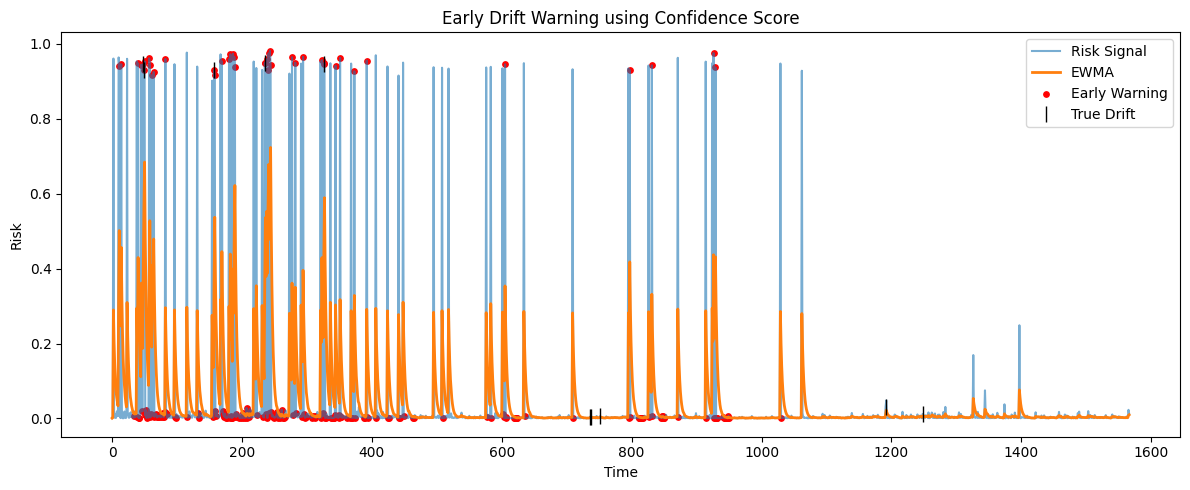

In [102]:
#Risk + EWMA + Confidence plot

plt.figure(figsize=(12,5))

plt.plot(risk_series, label="Risk Signal", alpha=0.6)
plt.plot(ewma, label="EWMA", linewidth=2)

plt.scatter(
    confidence_df[confidence_df["Confidence_Level"].isin(["Investigate","High Risk","Critical"])]["Time"],
    risk_series[confidence_df["Confidence_Level"].isin(["Investigate","High Risk","Critical"])],
    color="red", s=15, label="Early Warning"
)

plt.plot(np.where(true_drift==1)[0], risk_series[true_drift==1],
         "k|", markersize=12, label="True Drift")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Risk")
plt.title("Early Drift Warning using Confidence Score")
plt.tight_layout()
plt.show()


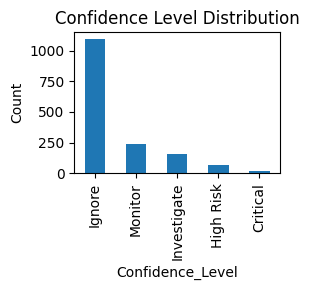

In [154]:
plt.figure(figsize=(5,3))
confidence_df["Confidence_Level"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.title("Confidence Level Distribution")
plt.tight_layout()
plt.show()



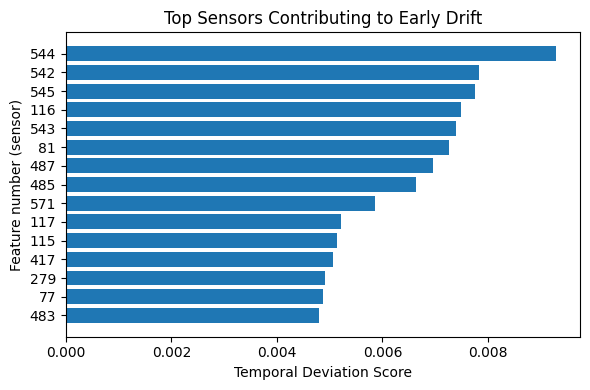

In [108]:
#Sensor Attrition
top_sensors = sensor_ranking.head(15)

plt.figure(figsize=(6,4))
plt.barh(
    top_sensors["Sensor_Index"].astype(str),
    top_sensors["Temporal_Deviation_Score"]
)
plt.gca().invert_yaxis()
plt.xlabel("Temporal Deviation Score")
plt.ylabel("Feature number (sensor)")
plt.title("Top Sensors Contributing to Early Drift")
plt.tight_layout()
plt.show()


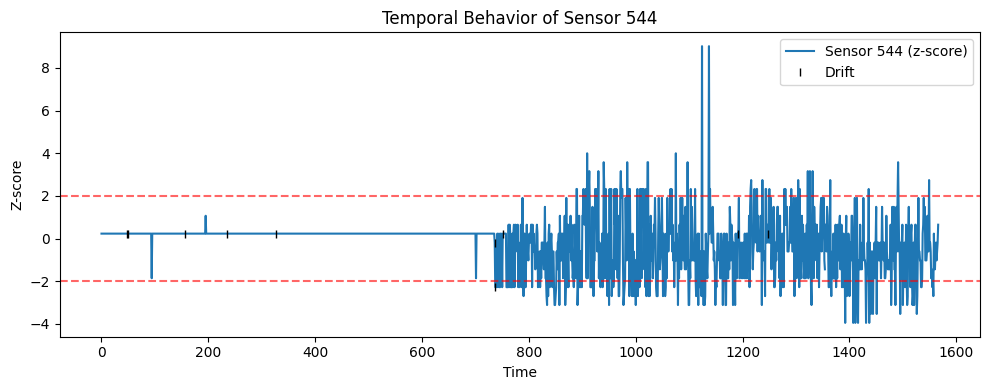

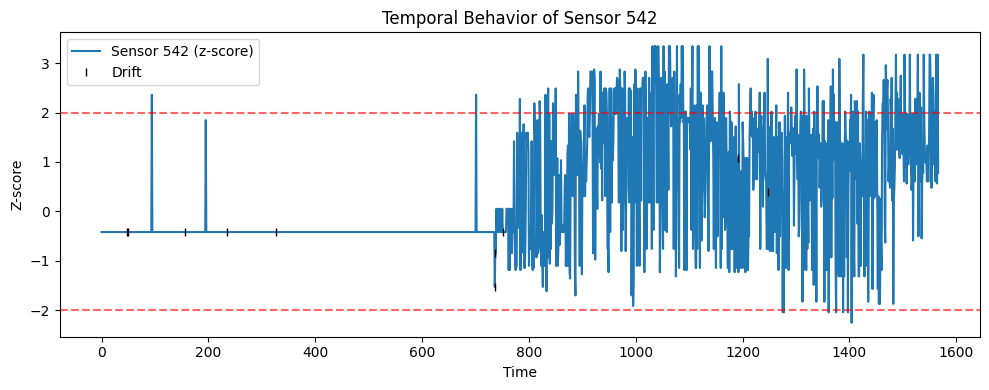

In [112]:
sensor_id = int(sensor_ranking.iloc[0]["Sensor_Index"])

plt.figure(figsize=(10,4))
plt.plot(sensor_z[:, sensor_id], label=f"Sensor {sensor_id} (z-score)")
plt.axhline(2, linestyle="--", color="red", alpha=0.6)
plt.axhline(-2, linestyle="--", color="red", alpha=0.6)

plt.plot(np.where(true_drift==1)[0],
         sensor_z[true_drift==1, sensor_id],
         "k|", label="Drift")

plt.legend()
plt.title(f"Temporal Behavior of Sensor {sensor_id}")
plt.xlabel("Time")
plt.ylabel("Z-score")
plt.tight_layout()
plt.show()

sensor_id = int(sensor_ranking.iloc[1]["Sensor_Index"])

plt.figure(figsize=(10,4))
plt.plot(sensor_z[:, sensor_id], label=f"Sensor {sensor_id} (z-score)")
plt.axhline(2, linestyle="--", color="red", alpha=0.6)
plt.axhline(-2, linestyle="--", color="red", alpha=0.6)

plt.plot(np.where(true_drift==1)[0],
         sensor_z[true_drift==1, sensor_id],
         "k|", label="Drift")

plt.legend()
plt.title(f"Temporal Behavior of Sensor {sensor_id}")
plt.xlabel("Time")
plt.ylabel("Z-score")
plt.tight_layout()
plt.show()


In [ ]:
#False alarm vs lead time - trade off

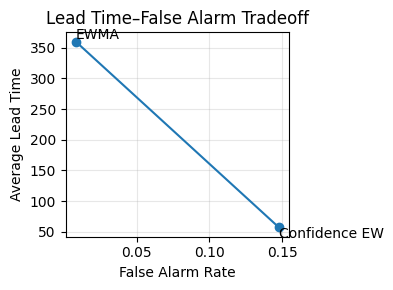

In [155]:
plt.figure(figsize=(4,3))

plt.plot(
    [false_alarm_rate(ewma_alarm, true_drift),
     false_alarm_rate(confidence_trigger, true_drift)],
    [np.mean(lead_ewma), np.mean(lead_conf)],
    "-o"
)

plt.text(
    false_alarm_rate(ewma_alarm, true_drift),
    np.mean(lead_ewma),
    "EWMA",
    va="bottom"
)

plt.text(
    false_alarm_rate(confidence_trigger, true_drift),
    np.mean(lead_conf),
    "Confidence EW",
    va="top"
)

plt.xlabel("False Alarm Rate")
plt.ylabel("Average Lead Time")
plt.title("Lead Time–False Alarm Tradeoff")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

